In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
!pip install tensorflow-gpu==2.1.0
import tensorflow as tf
tf.__version__

     |████████████████████████████████| 421.8MB 28kB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 450kB 54.1MB/s 
     |████████████████████████████████| 3.9MB 46.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=8d18f97cbc979edf1696f4670f6064713d70890e4786a44b01961882c8783bec
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorboard~=2.4, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installa

'2.1.0'

In [2]:
###Load images and labels
### Clone and save images in Colab Directory
! git clone https://github.com/rb05751/PicarProject.git

Cloning into 'PicarProject'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 1837 (delta 2), reused 0 (delta 0), pack-reused 1823
Receiving objects: 100% (1837/1837), 256.15 MiB | 26.36 MiB/s, done.
Resolving deltas: 100% (641/641), done.
Checking out files: 100% (3438/3438), done.


In [3]:
import os
import time

def img_preprocess(img):
  img = np.array(img, dtype = np.uint8)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  img = np.array(cv2.resize(img, (320,120)) / 255)
  return img

data = os.listdir('PicarProject/Code/Images/NewImages/')
images = []
for i in range(1,len(data)):
  try:
    img = mpimg.imread(f'PicarProject/Code/Images/NewImages/image{str(i)}.jpg')
    images.append(img_preprocess(img))
  except:
    continue

print(len(images))

248


##Visualize a few images from the dataset


As you can tell the HSV colorspace transformation that was done in the image preprocessing function highlights the tape and makes everything else in the background mostly bright green. Research shows that for steering angle prediction tasks, transforming the colorspace from a regular RGB (BGR in OpenCV) --> HSV increases image classification accuracy.

3 images need to be removed in this order: 247, 127, -3



###I believe you need to remove image #247 because the labels are off

245


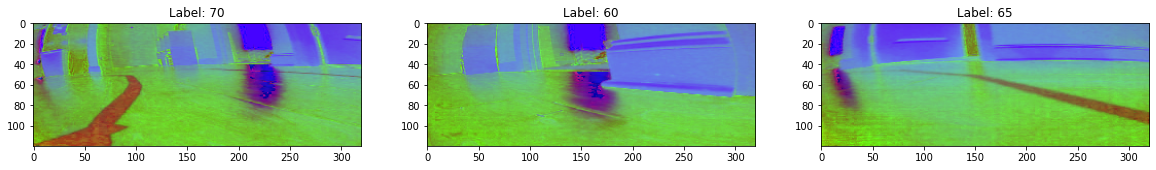

In [114]:
labels = [80,85,95,90,95,80,85,80,75,80,85,85,80,75,70,70,65,70,70,75,75,70,70,60,65,60,70,75,80,70,75,80,85,95,95,95,95,90,85,85,80,80,80,75,75,75,70,65,70,75,80,70,70,60,60,75,90,80,90,95,100,100,95,80,80,65,75,65,60,60,65,75,75,80,80,95,80,90,90,95,95,85,75,65,60,90,95,90,70,80,90,95,100,90,95,95,85,85,85,80,65,60,60,65,60,80,80,60,80,70,70,65,60,70,60,70,65,60,60,70,65,60,75,90,80,80,65,80,85,85,80,80,80,85,90,85,80,80,60,80,75,80,80,90,90,80,65,85,70,80,100,90,85,85,95,85,75,60,65,75,65,65,70,90,75,95,100,95,95,85,70,75,70,60,65,60,70,70,80,80,85,85,75,80,75,65,60,60,80,85,90,95,85,75,65,70,65,70,65,70,85,90,85,95,95,90,80,75,65,65,65,65,70,70,65,70,75,80,85,95,100,100,95,95,95,90,75,70,65,80,75,70,60,65,75,80,95,95,90,75,70,65,70,60,65]
print(len(labels))
plt.figure(figsize = (20,20))
idx = np.random.randint(1,261)
idx = 242
indices = [idx] + [idx + i for i in range(1,3)]
plt.subplot(131), plt.imshow(images[indices[0]]), plt.title(f'Label: {labels[indices[0]]}')
plt.subplot(132), plt.imshow(images[indices[1]]), plt.title(f'Label: {labels[indices[1]]}')
plt.subplot(133), plt.imshow(images[indices[2]]), plt.title(f'Label: {labels[indices[2]]}');
# images.pop(247)
# images.pop(127) ###This comment is for removing a rogue image in the dataset from when I picked the car up while it was capturing an image.
# images.pop(-3)

245
245


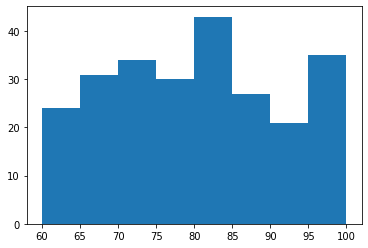

In [115]:
print(len(labels))
print(len(images))
x = list(range(60,100, 5))
plt.hist(labels, bins = 8);

###Image Augmentation and Other Helper Functions

Each image in the dataset is zoomed into, flipped, and blurred. Since the image pixels are normalized to values between 0-1 and Tensorflow convolutional models expect 4D tensors, we have a cam_prep function to handle the image processing prior to prediction.

NOTE: In a later version I decided to leave out zoom augmentation because of it causing labeling issues at certain parts of the track.

In [116]:
def zoom(img, angle):
  img =  tf.keras.preprocessing.image.random_zoom(img, zoom_range = (0.4, 0.4), row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.0, interpolation_order=1)
  if angle < 75:
    angle -= 10
  elif angle > 85:
    angle += 10
  else:
    angle = angle
  return img, angle

def cut(img):
  img = img[:, :, :]
  return img

def flip_image(img, angle):
    img = np.array(tf.image.flip_left_right(img))
    angle = 80 - (angle - 80)
    return img, angle

def blur_image(img, angle):
  img = cv2.blur(img, (9,9))
  return img, angle

def cam_prep(preprocessed_img):
  img = np.squeeze(np.expand_dims(preprocessed_img, axis = 0))
  img = np.array(preprocessed_img)
  img = img * 255
  img = img.astype(int)
  return img

img, _ = zoom(images[0], angle = 0)
img.shape

(120, 320, 3)

In [117]:
training_images = []

for img in images:
    #Augment Images
    f_img, _ = flip_image(img, angle = 0)
    b_img, _ = blur_image(img, angle = 0)
    # z_img, _ = zoom(img, angle = 0)

    #Add them to their respective lists
    training_images.append(img)
    training_images.append(f_img)
    training_images.append(b_img)
    # training_images.append(z_img)

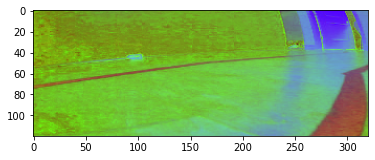

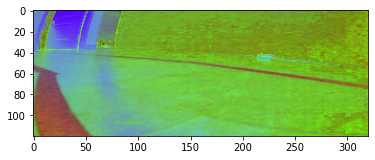

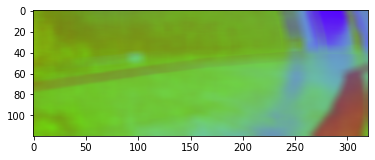

In [118]:
idx = np.random.randint(len(images))
idx = 540
plt.imshow(training_images[idx])
plt.show()
plt.imshow(training_images[idx + 1])
plt.show()
plt.imshow(training_images[idx + 2])
plt.show()

[(55, 7), (60, 76), (65, 83), (70, 95), (75, 60), (80, 159), (85, 88), (90, 73), (95, 80), (100, 14)]


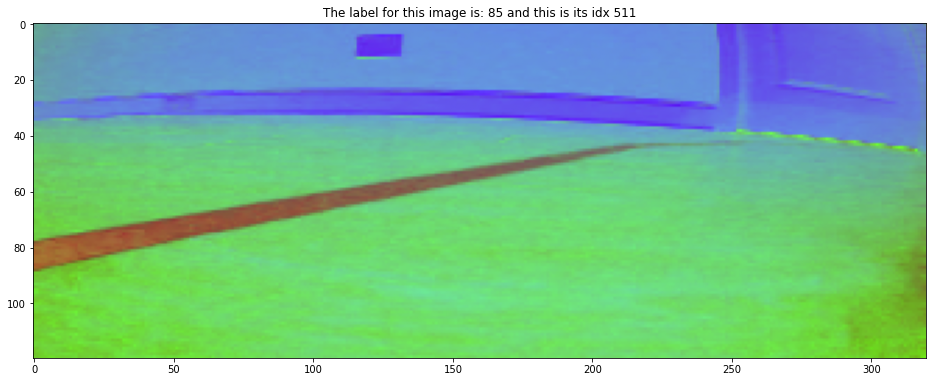

In [119]:
label_list = []
for label in labels:
  label_list.append(label) #original

  ##Flip
  if label > 80:
    label_list.append(int(80 - (label - 75))) 
  elif label < 80:
    label_list.append(int(80 - (label - 75))) 
  else:
    label_list.append(int(80 - (label - 80)))

  #blur
  label_list.append(label) 

# plt.hist(label_list, bins = 10)
ctr = dict()
for label in label_list:
  if ctr.get(label, 0) == 0:
    ctr[label] = 1
  else:
    ctr[label] += 1

print(sorted(ctr.items(), key = lambda x: (x[0], x[1])))
idx = np.random.randint(len(training_images))
idx = 511
plt.figure(figsize = (16,10))
plt.title(f"The label for this image is: {label_list[idx]} and this is its idx {idx}")
plt.imshow(training_images[idx]);

In [120]:
labels = []
angles = list(range(55,105, 5))

for lab in label_list:
  idx = angles.index(lab)
  labels.append(idx)

print(f"First 10 labels: {labels[:10]}")
print(f"The respective steering angles :{label_list[:10]}")
print(f"Number of training labels: {len(labels)}")
print(f"Number of training images: {len(training_images)}")

First 10 labels: [5, 5, 5, 6, 3, 6, 8, 1, 8, 7]
The respective steering angles :[80, 80, 80, 85, 70, 85, 95, 60, 95, 90]
Number of training labels: 735
Number of training images: 735


Number of lefts: 321
Number of straights: 159
Number of rights: 255
Total number of observations: 735


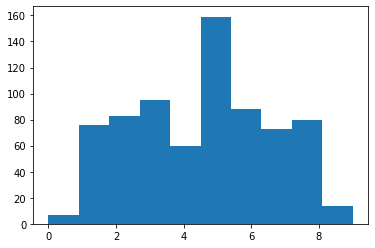

In [124]:
lefts = np.sum([1 for lab in labels if lab < 5])
straights = np.sum([1 for lab in labels if lab == 5])
rights = np.sum([1 for lab in labels if lab > 5])

print(f"Number of lefts: {lefts}")
print(f"Number of straights: {straights}")
print(f"Number of rights: {rights}")
print(f"Total number of observations: {len(labels)}")
plt.hist(labels, bins = 10);

###This is just another sanity check to make sure that the images are labeled correctly after binning them.

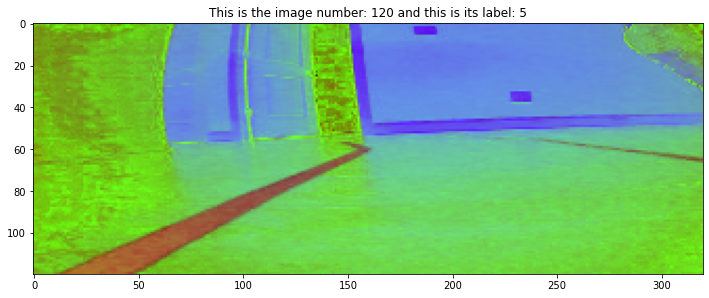

In [126]:
plt.figure(figsize = (12,8))
num = np.random.randint(1,len(labels))
plt.title(f'This is the image number: {num} and this is its label: {labels[num]}')
plt.imshow(training_images[num]);

#Model Training 

During model training, you will notice that the model is overfitting to the training data. The training accuracy is close to 100% and the validation accuracy hovers between 65-75% throughout training with the test accuracy coming in around 60-65% consistently. Through experimentation, I realized that the model achieved its highest validation and test accuracies when the training accuracy was around 100%. Adding dropout and removing layers to reduce training accuracy showed no improvement in validation or test accuracy, only a reduction in training accuracy. In some cases, reducing the training accuracy actually reduced the validation accuracy by the same reduction of the training accuracy.


In [128]:
data = np.reshape(training_images, (len(training_images), training_images[0].shape[0], training_images[0].shape[1], training_images[0].shape[2]))
labels = np.reshape(labels, (len(labels), 1))
print(f'Labels shape: {labels.shape}')
print(f'Images shape: {data.shape}')

Labels shape: (735, 1)
Images shape: (735, 120, 320, 3)


In [129]:
import random
all_indices = list(range(data.shape[0]))
random.shuffle(all_indices)

train_split = int(0.8*len(all_indices))
test_split = int(0.9*len(all_indices))

train_idx = all_indices[:train_split]
validation_idx = all_indices[train_split:test_split]
test_idx = all_indices[test_split:]

train_x, train_y = data[train_idx], labels[train_idx]
val_x, val_y = data[validation_idx], labels[validation_idx]
test_x, test_y = data[test_idx], labels[test_idx]

print(f'Length of train_data: {train_x.shape[0]}')
print(f'Length of validation data: {val_x.shape[0]}')
print(f'Length of test data: {test_x.shape[0]}')
print(f'Length of all indices: {len(all_indices)}')

Length of train_data: 588
Length of validation data: 73
Length of test data: 74
Length of all indices: 735


In [176]:
##Train model

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters = 16, kernel_size=3, input_shape = (120,320,3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size = (3,3)),
  tf.keras.layers.Conv2D(filters = 64, kernel_size = 3,  kernel_regularizer=tf.keras.regularizers.l2(.3), strides = (2,2), activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size = (3,3)),
  tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, kernel_regularizer=tf.keras.regularizers.l2(.3), activation = 'relu'),
  tf.keras.layers.MaxPooling2D(pool_size = (3,3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512),
  tf.keras.layers.Dense(10, activation = 'softmax')
])

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 118, 318, 16)      448       
_________________________________________________________________
batch_normalization_59 (Batc (None, 118, 318, 16)      64        
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 39, 106, 16)       0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 19, 52, 64)        9280      
_________________________________________________________________
batch_normalization_60 (Batc (None, 19, 52, 64)        256       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 6, 17, 64)         0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 4, 15, 128)      

In [185]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 / 10**(epoch / 25))

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

optimizer = tf.keras.optimizers.Adam(lr=1e-4)

model.compile(loss= 'sparse_categorical_crossentropy' ,optimizer=optimizer, metrics= ['sparse_categorical_accuracy']) ##Need to implement a weighted loss function.


history = model.fit(x = train_x, y = train_y,  validation_data = (val_x, val_y), batch_size = 64, shuffle = True,  epochs=50) #Tensorboard is added to callbacks, remember dat

Train on 588 samples, validate on 73 samples
Epoch 1/50
588/588 [==============================] - 1s 2ms/sample - loss: 0.3354 - sparse_categorical_accuracy: 0.9830 - val_loss: 1.9834 - val_sparse_categorical_accuracy: 0.6712
Epoch 2/50
588/588 [==============================] - 0s 704us/sample - loss: 0.3145 - sparse_categorical_accuracy: 0.9847 - val_loss: 2.1470 - val_sparse_categorical_accuracy: 0.6301
Epoch 3/50
588/588 [==============================] - 0s 717us/sample - loss: 0.3249 - sparse_categorical_accuracy: 0.9813 - val_loss: 2.2737 - val_sparse_categorical_accuracy: 0.6027
Epoch 4/50
588/588 [==============================] - 0s 726us/sample - loss: 0.3187 - sparse_categorical_accuracy: 0.9813 - val_loss: 2.1639 - val_sparse_categorical_accuracy: 0.6438
Epoch 5/50
588/588 [==============================] - 0s 724us/sample - loss: 0.3319 - sparse_categorical_accuracy: 0.9796 - val_loss: 2.0248 - val_sparse_categorical_accuracy: 0.6712
Epoch 6/50
588/588 [=================

#Test Set Evaluation

The following two cells are for evaluating the models accuracy on the test set and to visualize the steering angle probabilities that it predicted on a random image.

74/74 [==============================] - 0s 570us/sample - loss: 2.7811 - sparse_categorical_accuracy: 0.6351


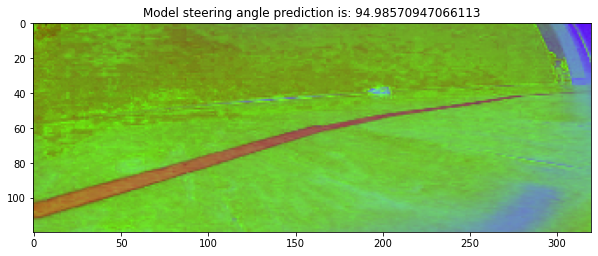

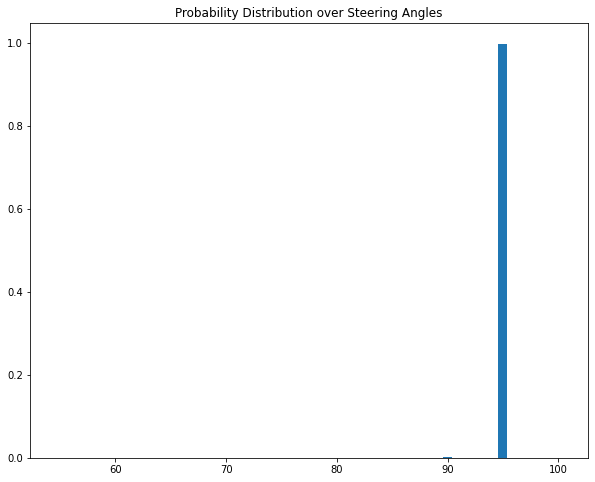

In [205]:
image_num = np.random.randint(0,test_x.shape[0]) ##Generate random index
pred = model.predict(tf.expand_dims(test_x[image_num], axis = 0)) # Make a prediction on that image
angles = np.array(list(range(55,105,5)))
test = model.evaluate(test_x, test_y)
plt.figure(figsize = (10,8))
plt.imshow(np.squeeze(test_x[image_num]))
plt.title(f'Model steering angle prediction is: {np.dot(pred[0], angles)}')
plt.show()
plt.figure(figsize = (10,8))
plt.bar(x = angles, height = pred[0])
plt.title('Probability Distribution over Steering Angles')
plt.show()

In [ ]:
# Save the entire model as a SavedModel.
model.save('/content/PicarProject/tf_model_1230_new.h5')